# Task2: Comparison of normalization methods for classification on Image dataset 2
- Model: MLFFNN with 2 hidden layers and tanh activation function
- Loss function: Cross-entropy
- Mode of learning: Mini-batch mode
- Stopping criterion: Change in average error below a threshold
- Weight update rule: AdaM
- Normalization method:
    1. No normalization, 
    2. Batch normalization with post-activation normalization
- Use the same value of learning rate parameter
- Use the same initial random values of weights
- For each normalization method, report should include the following:
    1. Plot of average error on training data vs Epoch,
    2. Confusion matrices for training data and test data
- Compare number of epochs taken for convergence for normalization methods

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [17]:
# Get Data
train_data = pd.read_csv("task 2/train_data.csv", names = ["feature_" + str(i) for i in range(1, 37)])
train_label = pd.read_csv("task 2/train_label.csv", names = ["label"])

val_data = pd.read_csv("task 2/val_data.csv", names = ["feature_" + str(i) for i in range(1, 37)])
val_label = pd.read_csv("task 2/val_label.csv", names = ["label"])

test_data = pd.read_csv("task 2/test_data.csv", names = ["feature_" + str(i) for i in range(1, 37)])
test_label = pd.read_csv("task 2/test_label.csv", names = ["label"])

In [18]:
# Prepare data in desirable format
# Since we need to use mini batch training we can use Dataloader class to create batches stored in DataLoader Object.
X_train = torch.FloatTensor(train_data.values)
Y_train = torch.LongTensor(train_label.values)
train = TensorDataset(X_train, Y_train)

X_val = torch.FloatTensor(val_data.values)
Y_val = torch.LongTensor(val_label.values)
val = TensorDataset(X_val, Y_val)

X_test = torch.FloatTensor(test_data.values)
Y_test = torch.LongTensor(test_label.values)
test = TensorDataset(X_test, Y_test)

In [19]:
# Create dataloaders
train_dataloader = DataLoader(train, batch_size = 16, shuffle = True)
val_dataloader = DataLoader(val, batch_size = 16, shuffle = False)
test_dataloader = DataLoader(test, batch_size = 16, shuffle = False)

In [20]:
# Create Model with 2 hidden layers
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batchnorm = False):
        super().__init__() ## This is called inheritance i.e. child can call parent
        self.batchnorm = batchnorm
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.logSoftmax = nn.LogSoftmax()
        
        if batchnorm:
            self.bn1 = nn.BatchNorm1d(hidden_size)
            self.bn2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, x):
        x = self.i2h(x)
        if self.batchnorm:
            x = self.bn1(x)
        # BatchNorm normalizes the output of the linear layer, ensuring the activations are within a stable range, 
        # which can help with training stability and convergence
        x = F.tanh(x)
        
        x = self.h2h(x)
        if self.batchnorm:
            x = self.bn2(x)
        x = F.tanh(x)
        
        x = self.logSoftmax(self.h2o(x))
        return x

In [21]:
# Seed
torch.manual_seed(0)

# Fixed variables
BatchNormalization = [False, True]
Learning_rate = 0.01

Training_Loss = {}
Validation_Loss = {}
Test_accuracy = {}
Convergence_epoch = {}

patience = 5  # Number of epochs to wait for improvement
threshold = 1e-6  # Minimum change in loss to continue

for batchnorm in BatchNormalization:
    model = Model(36, 18, 5, batchnorm)
    loss_criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate)
    epochs = 20
    
    train_loss = []
    val_loss = []
    
    # Initialize variables for stopping criteria
    best_val_loss = float("inf")
    no_improve_epochs = 0  # Counter for non-improvement epochs
    
    for e in range(1, epochs+1):
        model.train()
        epoch_train_loss = 0
        for data, label in iter(train_dataloader):
            y_train_pred = model.forward(data)
            loss = loss_criteria(y_train_pred, label.squeeze(dim=1))
            epoch_train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_train_loss /= len(train_dataloader)
        train_loss.append(epoch_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        for data, label in iter(val_dataloader):
            with torch.no_grad():
                y_val_pred = model.forward(data)
                loss_val = loss_criteria(y_val_pred, label.squeeze(dim=1))
                epoch_val_loss += loss_val.item()
        
        epoch_val_loss /= len(val_dataloader)
        val_loss.append(epoch_val_loss)
                
        if e % 5 == 0:
            print(f"[Batch normalization = {batchnorm}] Epoch {e}: Training Loss = {epoch_train_loss:.4f}, Validation Loss = {epoch_val_loss:.4f}")
        
        if loss_val.item() < best_val_loss - threshold:
            best_val_loss = loss_val.item()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs >= patience:
            Convergence_epoch[str(batchnorm)] = e
            print(f"[Batch normalization = {batchnorm}] Early stopping at epoch {e}: No improvement in validation loss for {patience} epochs.")
            break
    
    model.eval()
    with torch.no_grad():
        Y_test_pred = model.forward(X_test).argmax(dim=1)
        accuracy = accuracy_score(Y_test_pred.numpy(), Y_test.squeeze(dim=1).numpy())
        Test_accuracy[str(batchnorm)] = accuracy
    
    Training_Loss[str(batchnorm)] = train_loss
    Validation_Loss[str(batchnorm)] = val_loss

/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Batch normalization = False] Epoch 5: Training Loss = 1.3444, Validation Loss = 1.3293
[Batch normalization = False] Early stopping at epoch 7: No improvement in validation loss for 5 epochs.


/home/btech/mm20b007/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Batch normalization = True] Epoch 5: Training Loss = 1.3003, Validation Loss = 1.3401
[Batch normalization = True] Early stopping at epoch 6: No improvement in validation loss for 5 epochs.


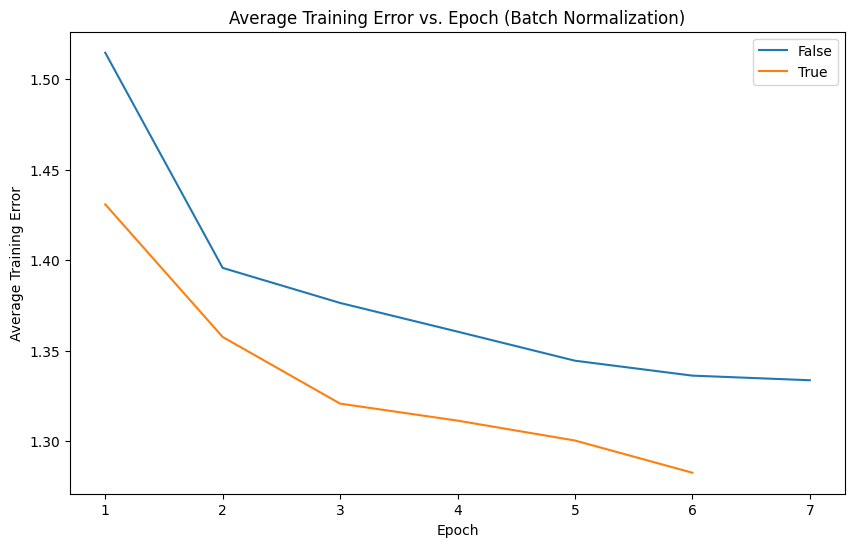

Batch Normalization False converged in 7 epochs.
Batch Normalization True converged in 6 epochs.
The test accuracy for batch normalization False = 0.44.
The test accuracy for batch normalization True = 0.474.


In [22]:
# (a) Combined Plot for All Optimizers
plt.figure(figsize=(10, 6))
for name, losses in Training_Loss.items():
    plt.plot(range(1, len(losses) + 1), losses, label=name)

plt.xlabel("Epoch")
plt.ylabel("Average Training Error")
plt.title("Average Training Error vs. Epoch (Batch Normalization)")
plt.legend()
plt.show()

# Compare convergence epochs
for name, epoch in Convergence_epoch.items():
    print(f"Batch Normalization {name} converged in {epoch} epochs.")
    
# Compare accuracy
for name, accuracy in Test_accuracy.items():
    print(f"The test accuracy for batch normalization {name} = {accuracy}.")